# Initial Preprocessing of UW-Madison Data
## (into 3D numpy array)

This file performs initial preprocessing of the UW-Madison dataset,
starting with the data as provided for the Kaggle competition,
and targeting 3D representation as a numpy array.

The reason to target 3D representation from the earliest preprocessing step are:
* Value clipping in 2D segmen done during preprocessing does not consider adjacent segments which may have values outside the curdrent image's range. This clipping approach will generate discontinuities in the depth dimension
* Autmentations are limited to 2D, so 3D representation learning does not benefit fromaugmentation in the third dimension.
* IoU/F1 score is strictly 2D, so the cost function does not reflect depth, and weight training does not benefit from depth.

---

The dataset comes from the UWMadison GI-Track Segmentation Kaggle Competition:
* https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/

The code here is largely copied/reused from an example provided by Kaggle competitor "AWSAF49"
* https://www.kaggle.com/code/awsaf49/uwmgi-mask-data

---

The input to this script is the dataset as provided for the competition
* 2.3G uw-madison-gi-tract-image-segmentation.zip

Once unzipped it includes
* MRI samples within a folder hierarchy which identifies the case (patient), day, and scan (slice).
* A single "training.csv" file that contains run-length encoding (RLE) of 3 segments of the brain, for a subset of the images.

An MRI is a set of scans that represent a 3D volume. Each scan is a 2D slice through the brain at a particular depth. Scans are in .png format and are a 16-bit grayscale image. Scans are co-located in the folder with it's peers for that MRI. 

A patient typically has several MRI samples, taken on different days.

---

This file performs the following:
* RLE segmentation data for [large_bowel, small_bowel, stomach] is read and used to generate a 3D mask of dimensions [H,W,D] where H=heigh, W=width, and D=depth. Depth is the number of scans in the MRI. Each voxel is uint8 valued as:
* 0 (binary 000) -> no classes
* 1 (binary 001) -> class A
* 2 (binary 010) -> class B
* 3 (binary 011) -> class A, B
* 4 (binary 100) -> class C
* 5 (binary 101) -> class A, C
* 6 (binary 110) -> class B, C
* 7 (binary 111) -> class A, B, C

The masks are written to file as .npy format.
* Note that the above one-hot encoding does not present itself easily as RGB - so viewing the masks will require a bit more effort.

In addition the grayscale MRI images are also re-written - here the "slices" are merged into a 3D numpy representation and written to a .npy file.


# Import Libraries

In [128]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm.notebook import tqdm
tqdm.pandas()
import time
import copy
import joblib
import gc
from IPython import display as ipd
from joblib import Parallel, delayed

# visualization
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import image as mpimg
from matplotlib.patches import Rectangle

In [2]:
pd.set_option('display.max_colwidth', None)

# Weights & Biases

<img src="https://camo.githubusercontent.com/dd842f7b0be57140e68b2ab9cb007992acd131c48284eaf6b1aca758bfea358b/68747470733a2f2f692e696d6775722e636f6d2f52557469567a482e706e67" width="400" alt="Weights & Biases" />

In [3]:
import wandb
wandb.login()

# try:
#     from kaggle_secrets import UserSecretsClient
#     user_secrets = UserSecretsClient()
#     api_key = user_secrets.get_secret("WANDB")
#     wandb.login(key=api_key)
# except:
#     wandb.login(anonymous='must',relogin=True)
#     print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cwinsor. Use `wandb login --relogin` to force relogin


True

# Utilities

In [4]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = np.asarray(mask_rle.split(), dtype=int)
    starts = s[0::2] - 1
    lengths = s[1::2]
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction


# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


# Metadata

In [5]:
def get_metadata(row):
    data = row['id'].split('_')
    case = int(data[0].replace('case',''))
    day = int(data[1].replace('day',''))
    slice_ = int(data[-1])
    row['case'] = case
    row['day'] = day
    row['slice'] = slice_
    return row

def path2info(row):
    path = row['image_path']
    data = path.split('/')
    slice_ = int(data[-1].split('_')[1])
    case = int(data[-3].split('_')[0].replace('case',''))
    day = int(data[-3].split('_')[1].replace('day',''))
    width = int(data[-1].split('_')[2])
    height = int(data[-1].split('_')[3])
    row['height'] = height
    row['width'] = width
    row['case'] = case
    row['day'] = day
    row['slice'] = slice_
    return row

# Mask

In [6]:
def id2mask(id_, df=None):
    idf = df[df['id']==id_]
    wh = idf[['height','width']].iloc[0]
    shape = (wh.height, wh.width, 3)
    mask = np.zeros(shape, dtype=np.uint8)
    for i, class_ in enumerate(['large_bowel', 'small_bowel', 'stomach']):
        cdf = idf[idf['class']==class_]
        rle = cdf.segmentation.squeeze()
        if len(cdf) and not pd.isna(rle):
            mask[..., i] = rle_decode(rle, shape[:2])
    return mask

def rgb2gray(mask):
    pad_mask = np.pad(mask, pad_width=[(0,0),(0,0),(1,0)])
    gray_mask = pad_mask.argmax(-1)
    return gray_mask

def gray2rgb(mask):
    rgb_mask = tf.keras.utils.to_categorical(mask, num_classes=4)
    return rgb_mask[..., 1:].astype(mask.dtype)

# Image

In [7]:
def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = img.astype('float32') # original is uint16
    img = (img - img.min())/(img.max() - img.min())*255.0 # scale image to [0, 255]
    img = img.astype('uint8')
    return img

def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
#     plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = [ "Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

# Read Case/Segmentation Data

In [8]:
df = pd.read_csv('/mnt/d/code_medimg_practice/data/train.csv')
# df = df.progress_apply(get_metadata, axis=1)
df = df.apply(get_metadata, axis=1)
df.head()

,id,class,segmentation,case,day,slice
0,case123_day20_slice_0001,large_bowel,NaN,123,20,1
1,case123_day20_slice_0001,small_bowel,NaN,123,20,1
2,case123_day20_slice_0001,stomach,NaN,123,20,1
3,case123_day20_slice_0002,large_bowel,NaN,123,20,2
4,case123_day20_slice_0002,small_bowel,NaN,123,20,2


# Merge in Image Paths

In [9]:
paths = glob('/mnt/d/code_medimg_practice/data/train/*/*/*/*')
path_df = pd.DataFrame(paths, columns=['image_path'])
# path_df = path_df.progress_apply(path2info, axis=1)
path_df = path_df.apply(path2info, axis=1)
df = df.merge(path_df, on=['case','day','slice'])
df.head()

,id,class,segmentation,case,day,slice,image_path,height,width
0,case123_day20_slice_0001,large_bowel,NaN,123,20,1,/mnt/d/code_medimg_practice/data/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png,266,266
1,case123_day20_slice_0001,small_bowel,NaN,123,20,1,/mnt/d/code_medimg_practice/data/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png,266,266
2,case123_day20_slice_0001,stomach,NaN,123,20,1,/mnt/d/code_medimg_practice/data/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png,266,266
3,case123_day20_slice_0002,large_bowel,NaN,123,20,2,/mnt/d/code_medimg_practice/data/train/case123/case123_day20/scans/slice_0002_266_266_1.50_1.50.png,266,266
4,case123_day20_slice_0002,small_bowel,NaN,123,20,2,/mnt/d/code_medimg_practice/data/train/case123/case123_day20/scans/slice_0002_266_266_1.50_1.50.png,266,266


# Check Mask

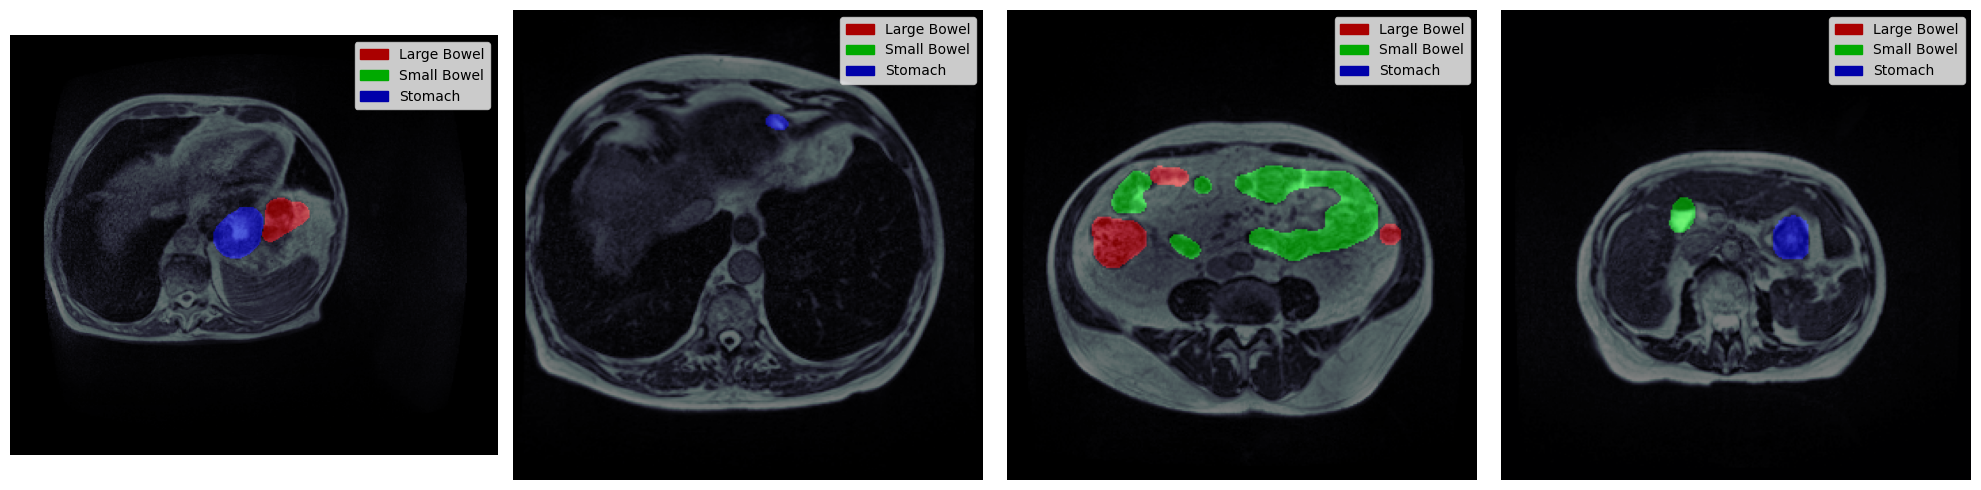

In [10]:
row=1; col=4
plt.figure(figsize=(5*col,5*row))
# the following line samples (row*col) unique IDs from that subset of the dataframe where "segmentation" is not N/A
# In other words - get four samples that have segmentation
for i, id_ in enumerate(df[~df.segmentation.isna()].sample(frac=1.0)['id'].unique()[:row*col]):
    img = load_img(df[df['id']==id_].image_path.iloc[0])
    mask = id2mask(id_,df=df)*255
    plt.subplot(row, col, i+1)
    i+=1
    show_img(img, mask=mask)
    plt.tight_layout()

# temporary - explore image and mask

in summary: df includes (3) entries for each image (a.k.a. case_id) - one for each segment
for example:
```
case34_day0_slice_0067
/mnt/d/code_medimg_practice/data/train/case34/case34_day0/scans/slice_0067_276_276_1.63_1.63.png
/mnt/d/code_medimg_practice/data/train/case34/case34_day0/scans/slice_0067_276_276_1.63_1.63.png
/mnt/d/code_medimg_practice/data/train/case34/case34_day0/scans/slice_0067_276_276_1.63_1.63.png
```
### Image
* An image is read from file using the load_img() function.
* That function performs only basic processing - converting from uint16 to uint8, and cropping values
* That function returns a numpy array of uint8 (between 0 and 255). Shape is variable.
* Image pixel values are a skewed mostly lower values.

### Mask
* A "mask" is generated using the id2mask function.
* That function:
  * generates a zero array having [height, width] same as the image, but with additional dimension of [3]
  * the pixels of that array are of type uint8
  * for each of the (3) segmentation RLE sequences ['large_bowel', 'small_bowel', 'stomach']
    * use the rle_decode to populate the array for that dimension 
  * the resulting array of shape [height, width, 3] having type uint8.
  * the resulting array has pixel values of [0,1] indicating pixel is of that segment type. The application performs *255 resulting in pixel values of [0, 255].




In [11]:
### explore...

# randomly sample from the dataframe, where segmentation is present, and choose the first
case_id = df[~df.segmentation.isna()].sample(frac=1.0)['id'].unique()[0]
print(case_id)

for y in (df[df['id']==case_id].image_path):
    print(y)

img = load_img(df[df['id']==case_id].image_path.iloc[0])
print(f"\ntype(img) {type(img)} img.shape {img.shape} type(img[0,0]) {type(img[0,0])}")
[print(y) for y in np.histogram(img)]


mask = id2mask(case_id, df=df)
print(f"\ntype(mask) {type(mask)} mask.shape {mask.shape} type(mask[0,0,0] {type(mask[0,0,0])}")
# [print(y) for y in np.histogram(mask[:,:,0])]
_ = [print(y) for y in np.histogram(mask[:,:,0])]
_ = [print(y) for y in np.histogram(mask[:,:,1])]
_ = [print(y) for y in np.histogram(mask[:,:,2])]



case49_day15_slice_0072
/mnt/d/code_medimg_practice/data/train/case49/case49_day15/scans/slice_0072_360_310_1.50_1.50.png
/mnt/d/code_medimg_practice/data/train/case49/case49_day15/scans/slice_0072_360_310_1.50_1.50.png
/mnt/d/code_medimg_practice/data/train/case49/case49_day15/scans/slice_0072_360_310_1.50_1.50.png

type(img) <class 'numpy.ndarray'> img.shape (310, 360) type(img[0,0]) <class 'numpy.uint8'>
[71760  9761 16506  8491  3674  1014   274   106    13     1]
[  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]

type(mask) <class 'numpy.ndarray'> mask.shape (310, 360, 3) type(mask[0,0,0] <class 'numpy.uint8'>
[109102      0      0      0      0      0      0      0      0   2498]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[109061      0      0      0      0      0      0      0      0   2539]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[111085      0      0      0      0      0      0      0      0    515]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


# Initiate Weights&Biases project

In [12]:
# Initialize WANDB project
run = wandb.init(project='uwmgi-mask-data', 
                 config={},
#                  anonymous=anonymous,
                 name=f"01b_initial_preprocessing_to_3d_npy",
                )
# Columns for wandb table
columns=["id", "case", "day", "slice", "empty", "image"]
# Initialize table
table = wandb.Table(columns=columns)
# Labels for mask
class_labels = {
#     0:"Background",
    1:"Large Bowel",
    2:"Small Bowel",
    3:"Stomach",
}

# Binary Mask Set to Encoded Mask
This function takes in 3 binary masks A, B, C and returns a single encoded mask.
The output encoding considers that a pixel may be considered more than one class...
```
input:  np array of size [H,D,3] of ulong8 having value [0 or 1]
output: np array of size [H,D]   of ulong8 having value (array[2]<<2 + array[1]<<1 + array[0]) where "<<" is bitwise shift left

  * Input:                  Output:
  * no classes            0 (binary 000)
  * class A = 1           1 (binary 001)
  * class B = 1           2 (binary 010)
  * class A, B = 1        3 (binary 011)
  * class C = 1           4 (binary 100)
  * class A, C = 1        5 (binary 101)
  * class B, C = 1        6 (binary 110)
  * class A, B, C = 1     7 (binary 111)
  ```

In [13]:
def encode_mask_set(mask_in):
    result = \
        np.left_shift(mask_in[:,:,2], 2) + \
        np.left_shift(mask_in[:,:,1], 1) + \
        np.left_shift(mask_in[:,:,0], 0)
    return result

In [14]:
# [print(x) for x in np.histogram(mask[:,:,2])]
# [print(x) for x in np.histogram(mask[:,:,1])]
# [print(x) for x in np.histogram(mask[:,:,0])]

In [15]:
# df.iloc[0]
# df.info()
# df.describe(include='all')
# df.head(1)

# Write 3D masks

In [16]:
# NO_EMPTY = True
# # case = case122_day24_slice_0070

# tmp_df = df.copy()
# print(f"NO_EMPTY={NO_EMPTY}")
# if NO_EMPTY:
#     tmp_df = tmp_df[~df.segmentation.isna()]
# ids = tmp_df['id'].unique()
# ids[0]

In [17]:
def save_3d_mask_single_case_day(base_folder, case, day, case_day_group):

    SLICE_INDEXING_BASE = 1  # seriously - the slice index is 1-based... doh

    height = case_day_group.iloc[0].height
    width = case_day_group.iloc[0].width
    depth = case_day_group.id.count() // 3

    image_groups = case_day_group.groupby(['id'])[['class', 'slice', 'image_path']]

    # 3d masks
    mask_folder = base_folder + '/masks'
    os.makedirs(mask_folder, exist_ok=True)

    mask_3d = np.zeros((height, width, depth), dtype=np.uint8)
    for (id), image_group in image_groups:
        mask_onehot = id2mask(id, df=df)
        mask_encoded = encode_mask_set(mask_onehot)
        slice = image_group.slice.iloc[0] - SLICE_INDEXING_BASE
        mask_3d[:, :, slice] = mask_encoded

    mask_file = f"{mask_folder}/case_{case}_day_{day}.npy"
    np.save(mask_file, mask_3d)

    # 3d images
    image_folder = base_folder + '/images'
    os.makedirs(image_folder, exist_ok=True)

    image_3d = np.zeros((height, width, depth), dtype=np.uint8)
    for (id), image_group in image_groups:
        slice = image_group.slice.iloc[0] - SLICE_INDEXING_BASE
        image_2d = image_group.image_path.unique()[0]
        single_image = load_img(image_2d)
        image_3d[:, :, slice] = single_image

    image_file = f"{image_folder}/case_{case}_day_{day}.npy"
    np.save(image_file, image_3d)


In [18]:
def save_3d_mask_all_case_and_days(df):

    base_folder = '/mnt/d/code_medimg_aneja_lab/data_uwmadison_01c_preprocessed_3d'
    os.makedirs(base_folder, exist_ok=True)
    
    case_day_groups = df.groupby(['case', 'day'])[['slice', 'class', 'image_path', 'id', 'height', 'width']]

    # for (case, day), case_day_group in case_day_groups:
    #     save_3d_mask_single_case_day(case, day, case_day_group)

    _ = Parallel(n_jobs=-1, backend='threading')(delayed(save_3d_mask_single_case_day)(base_folder, case, day, case_day_group)\
                                                 for (case, day), case_day_group in case_day_groups)



In [19]:
# save_3d_mask_all_case_and_days(df)

# 3D Image Utilities

In [176]:
def load_3d(folder, subfolder, case_day):    
    path = f"{folder}/{subfolder}/{case_day}.npy"
    # print(path)
    img = np.load(path, encoding='bytes')
    return img

def show_3d(folder, case_day, num_wanted, show_mask, scale):

    image_3d = load_3d(folder, "images", case_day)
    if show_mask:
        mask_3d = load_3d(folder, "masks", case_day)

    max_slice = image_3d.shape[2]
    if num_wanted== -1:
        num_wanted = max_slice + 1
    # slices = [max_slice  * (sample_num + 1)  // (num_wanted+1) for sample_num in range(num_wanted)]
    slices = [92] # zona
    print(f"slices {slices}")

    nrows = len(slices)
    ncols = 2
    plt.figure(1)
    fix, axs = plt.subplots(nrows, ncols, figsize=(ncols*scale, nrows*scale),
                            subplot_kw={'xticks': [], 'yticks': []})

    index = 0
    for slice in slices:

        index += 1
        plt.subplot(nrows, ncols, index)
        plt.title(f"Slice {slice}")

        image_2d = image_3d[:, :, slice]
        plt.imshow(image_2d,  interpolation='none', cmap='bone')
        # plt.imshow(image_2d)

        index += 1
        if show_mask:
            mask_2d = mask_3d[:, :, slice]
            counts, buckets = np.histogram(mask_2d, bins=256, range=(-0.5, 255.5))
            count_string = (f"noclass:{counts[0]}\n" +
                            f"a:{counts[1]} b:{counts[2]} c:{counts[4]}\n" +
                            f"ab:{counts[3]} ac:{counts[5]} bc:{counts[6]} abc:{counts[7]}")

            # mask_2d_normalized = mask_3d_normalized[:, :, slice]
            # print(np.histogram(mask_2d, bins=8, range=(-0.5, 7.5)))
        
            plt.subplot(nrows, ncols, index)
            plt.title(count_string, loc='left')
            # plt.imshow(mask_2d_normalized)
            # plt.imshow(mask_2d_normalized, cmap='bone')
            # plt.imshow(mask_2d, cmap = plt.colormaps["plasma"])
            # plt.imshow(mask_2d, cmap = plt.colormaps["inferno"])
            # plt.imshow(mask_2d, vmin=0, vmax=7, cmap = plt.colormaps["magma"])
            plt.imshow(mask_2d, vmin=0, vmax=7, interpolation='none', cmap = plt.colormaps["nipy_spectral"])


        #     # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        #     plt.imshow(mask, alpha=0.5)
        #     handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        #     labels = [ "Large Bowel", "Small Bowel", "Stomach"]
        #     plt.legend(handles,labels)


# Check 3D Image (series of 2D slices)

slices [92]


<Figure size 640x480 with 0 Axes>

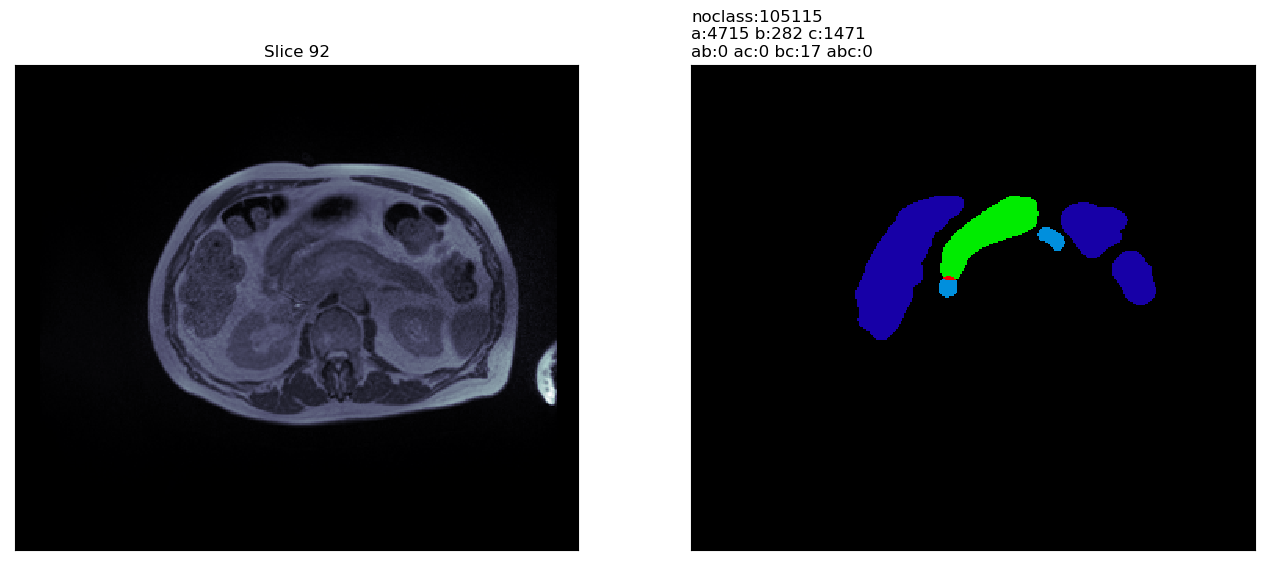

In [177]:
base_folder = '/mnt/d/code_medimg_aneja_lab/data_uwmadison_01c_preprocessed_3d'
case_day = 'case_85_day_29'
show_3d(base_folder, case_day, num_wanted=-1, show_mask=True, scale=8)


# Visualizing 3D

https://www.geeksforgeeks.org/displaying-3d-images-in-python/

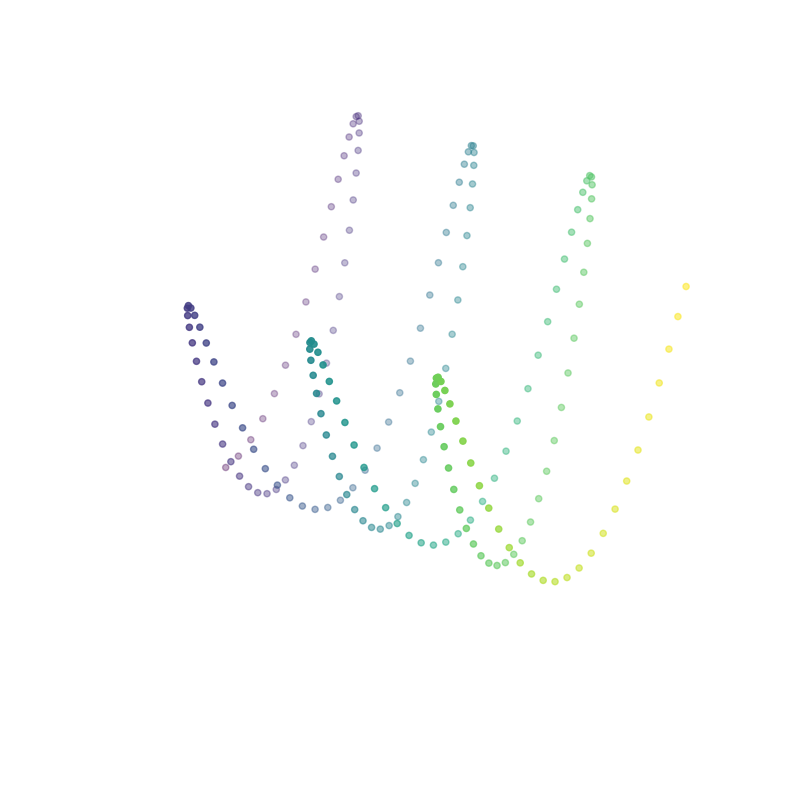

In [178]:

# Import libraries
# import numpy as np
# import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
 
# Change the Size of Graph using 
# Figsize
fig = plt.figure(figsize=(10, 10))
 
# Generating a 3D sine wave
ax = plt.axes(projection='3d')
 
# Creating array points using 
# numpy
x = np.arange(0, 20, 0.1)
y = np.sin(x)
z = y*np.sin(x)
c = x + y
 
# To create a scatter graph
ax.scatter(x, y, z, c=c)
 
# turn off/on axis
plt.axis('off')
 
# show the graph
plt.show()

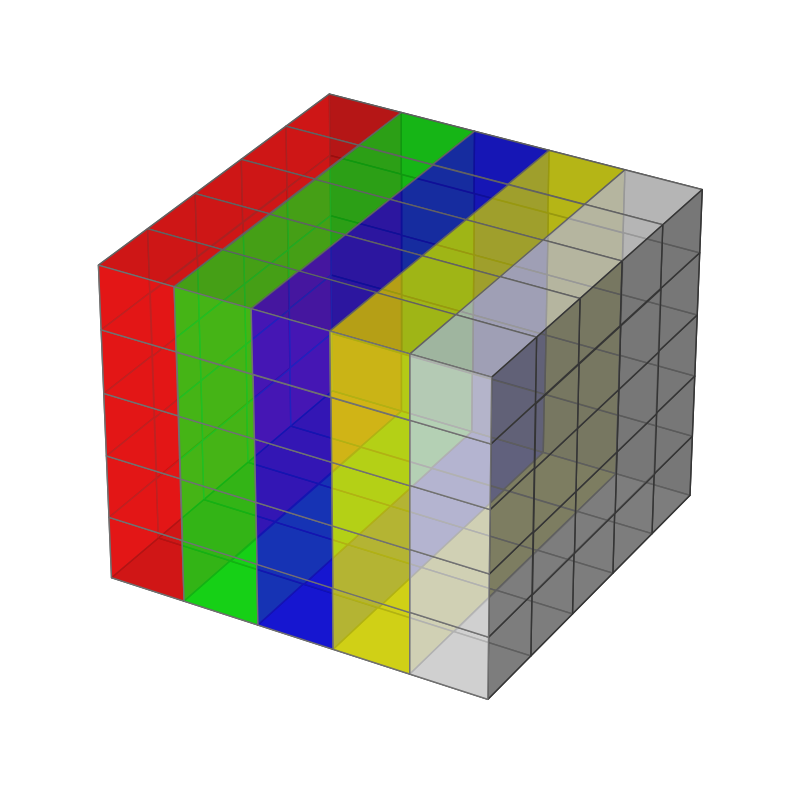

In [183]:
# Import libraries
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import numpy as np
 
# Change the Size of Graph using 
# Figsize
fig = plt.figure(figsize=(10, 10))
 
# Generating a 3D sine wave
ax = plt.axes(projection='3d')
 
# Create axis
axes = [5, 5, 5]
 
# Create Data
data = np.ones(axes)
 
# Control Tranperency
alpha = 0.7
 
# Control colour
colors = np.empty(axes + [4])
 
colors[0] = [1, 0, 0, alpha]  # red
colors[1] = [0, 1, 0, alpha]  # green
colors[2] = [0, 0, 1, alpha]  # blue
colors[3] = [1, 1, 0, alpha]  # yellow
colors[4] = [1, 1, 1, alpha]  # grey
 
# turn off/on axis
plt.axis('off')
 
# Voxels is used to customizations of
# the sizes, positions and colors.
_ = ax.voxels(data, facecolors=colors, edgecolors='grey')

AttributeError: module 'matplotlib.pyplot' has no attribute 'zlabel'

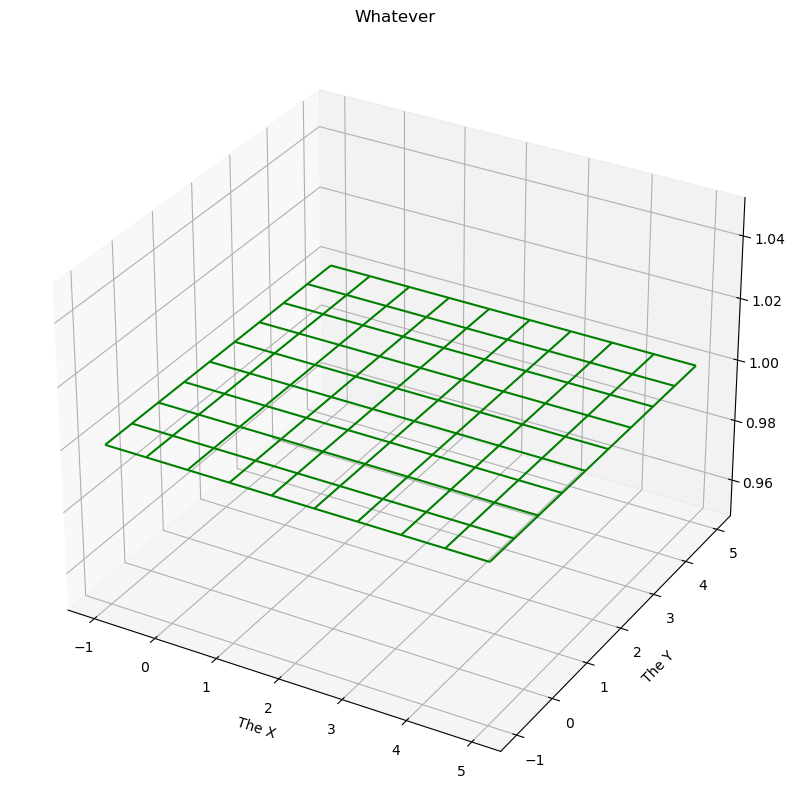

In [191]:

#Import libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
 
#Change the Size of Graph using Figsize
fig = plt.figure(figsize=(10,10))
 
#Generating a 3D sine wave
ax = plt.axes(projection='3d')
 
 
# assigning coordinates 
x = np.linspace(-1, 5, 10)
y = np.linspace(-1, 5, 10)
X, Y = np.meshgrid(x, y)
# Z = np.sin(np.sqrt(X ** 2 + Y ** 2))
Z = np.ones((len(x), len(x)))
 
# creating the visualization
ax.plot_wireframe(X, Y, Z, color ='green')
 
# turn off/on axis
plt.axis('on')
plt.title("Whatever")
plt.xlabel("The X")
plt.ylabel("The Y")
plt.zlabel("The Z")
plt.set_zlabel("foo")

x

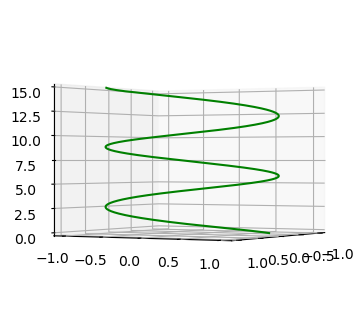

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [197]:

from numpy import linspace
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
 
 
# Creating 3D figure
fig = plt.figure(figsize=(4, 4))
ax = plt.axes(projection='3d')
 
# Creating Dataset
z = np.linspace(0, 15, 1000)
x = np.sin(z)
y = np.cos(z)
_ = ax.plot3D(x, y, z, 'green')
 
# 360 Degree view
for angle in range(0, 360):
    _ = ax.view_init(angle, 30)
    _ = plt.draw()
    _ = plt.pause(.1)
 
    _ = plt.show()